<a href="https://colab.research.google.com/github/changhyucklee/severstal-steel-defect-detection/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
import os
import keras
from keras.utils.all_utils import Sequence

from collections import Counter, defaultdict
from pathlib import Path
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [13]:
path = "/content/drive//My Drive/Colab Notebooks/severstal-steel-defect-detection/"
# print(os.path.join(path, "input/train.csv"))
train_df = pd.read_csv( os.path.join(path, "input/train.csv") )
sample_df = pd.read_csv( os.path.join(path, "input/sample_submission.csv") )

In [14]:
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [15]:
for img_filename in os.listdir(os.path.join(path, "input/train_images")):
    if img_filename not in list(train_df.ImageId):
        train_df = train_df.append({'ImageId': img_filename}, ignore_index=True)
train_df = train_df.sort_values("ImageId")

{0: 5902, 1: 6239, 2: 425, 3: 2}

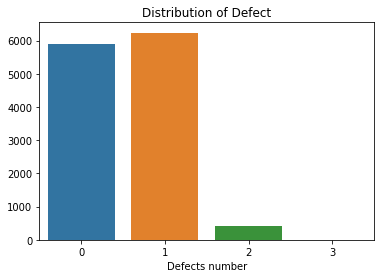

In [16]:
values_counter = list(Counter(train_df.loc[train_df.ClassId.isnull() == False, "ImageId"]).values())
# output = [1, 1, 1, 1, 2, ...]
values_counter = Counter(values_counter)

values_counter[0] = len(train_df.loc[train_df.ClassId.isnull(), "ImageId"])
values_counter= dict(sorted(values_counter.items(), key=lambda i: i[0]))  
# output = {0: 5902, 1: 6239, 2: 425, 3: 2}

fig, ax = plt.subplots()
sns.barplot(x=list(values_counter.keys()), y=list(values_counter.values()), ax=ax)
ax.set_title("Distribution of Defect")
ax.set_xlabel("Defects number")

values_counter

Counter({1.0: 897, 2.0: 247, 3.0: 5150, 4.0: 801})

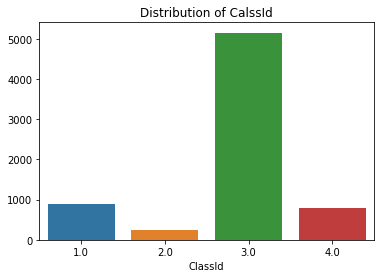

In [17]:
values_counter = Counter(train_df.loc[train_df.ClassId.isnull() == False, "ClassId"])
# output = Counter({1: 897, 3: 5150, 4: 801, 2: 247})
fig, ax = plt.subplots()
sns.barplot(x=list(values_counter.keys()), y=list(values_counter.values()), ax=ax)
ax.set_title("Distribution of CalssId")
ax.set_xlabel("ClassId")

values_counter

In [18]:
train2 = pd.DataFrame(columns=['ImageId', 'e1', 'e2', 'e3', 'e4'])  
for row in range(len(train_df)):
    if train_df.iloc[row, 0] not in list(train2.ImageId):
        train2 = train2.append({'ImageId' : train_df.iloc[row, 0]}, ignore_index=True)
    if np.isnan(train_df.iloc[row, 1]) == False:
        train2.loc[train2['ImageId'] == train_df.iloc[row, 0], f'e{int(train_df.iloc[row, 1])}'] = train_df.iloc[row, 2]
train2.reset_index(inplace=True,drop=True)
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:,1:]!='',axis=1).values
train2.head()

,ImageId,e1,e2,e3,e4,count
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1
1,00031f466.jpg,,,,,0
2,000418bfc.jpg,,,,,0
3,000789191.jpg,,,,,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1


In [19]:
# https://www.kaggle.com/ateplyuk/pytorch-starter-u-net-resnet
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = os.path.join(path, "input/train_images/")
        elif self.subset == "test":
            self.data_path = os.path.join(path, "input/test_images/")
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(str(self.data_path + f)).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None:
            X = self.preprocess(X)
        if self.subset == 'train':
            return X, y
        else: 
            return X

In [20]:
# https://www.kaggle.com/titericz/building-and-visualizing-masks
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3)

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

Train EDA

Let's confirm our Data Generator works and view some training images. We will only show examples with defects. Note that all mask contours are plotted with a little blank space around the defect to aid visualization. Below we show examples of each type but note that in the training set only 7.1%, 2.0%, 41.0%, 6.4% of images have defects 1, 2, 3, 4 respectively.

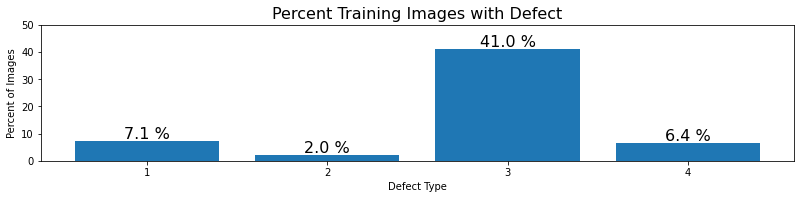

In [21]:
plt.figure(figsize=(13.5,2.5))
bar = plt.bar( [1,2,3,4],100*np.mean( train2.iloc[:,1:5]!='',axis=0) )
plt.title('Percent Training Images with Defect', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Defect Type')
plt.xticks([1,2,3,4])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=16)
plt.ylim((0,50)); plt.show()

[8497, 11884, 8220, 2054, 1421, 11979, 9053, 2976, 1535, 1890, 8610, 4030, 7616, 1827, 10404, 3577]
Images and masks from our Data Generator
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


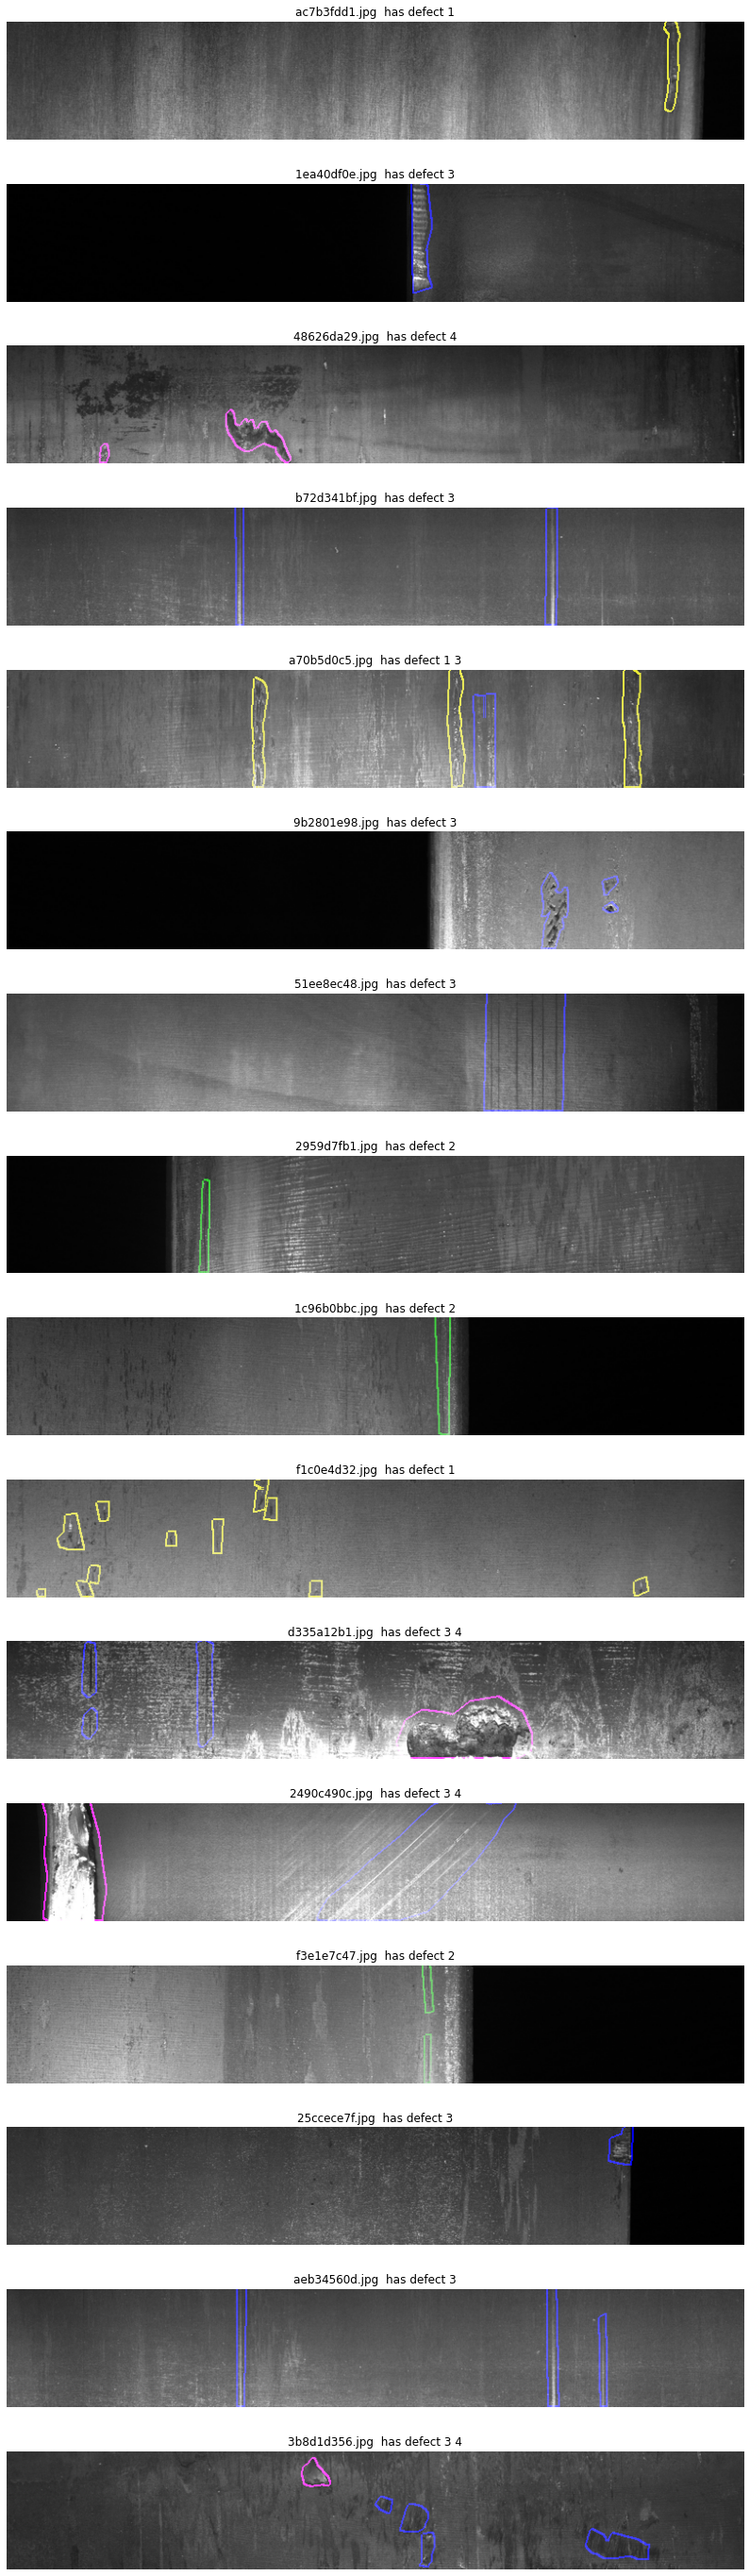

In [22]:
# DEFECTIVE IMAGE SAMPLES

filenames = {}
defects = list(train2[train2['e1']!=''].sample(3).index)
defects += list(train2[train2['e2']!=''].sample(3).index)
defects += list(train2[train2['e3']!=''].sample(7).index)
defects += list(train2[train2['e4']!=''].sample(3).index)
print(defects)

# DATA GENERATOR
train_batches = DataGenerator(train2[train2.index.isin(defects)],shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    plt.figure(figsize=(14,50))
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [23]:
! pip install segmentation-models

     |████████████████████████████████| 50 kB 7.0 MB/s 


In [24]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [25]:
from keras import backend as K
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [26]:
# LOAD UNET WITH PRETRAINING FROM IMAGENET
# preprocess = sm.get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
# callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# model = sm.Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

# # TRAIN AND VALIDATE MODEL
# idx = int(0.8*len(train2)); print()
# train_batches = DataGenerator(train2.iloc[:idx],shuffle=True,preprocess=preprocess)
# valid_batches = DataGenerator(train2.iloc[idx:],preprocess=preprocess)
# history = model.fit(train_batches, validation_data = valid_batches, epochs = 30, verbose=1, callbacks=[callback])

In [27]:
 # PLOT TRAINING
# plt.figure(figsize=(15,5))
# plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
# plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
# plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
# plt.show()

In [28]:
# model.save('UNET.h5')



In [29]:
# LOAD MODEL
from keras.models import load_model
model = load_model(os.path.join(path, "UNET/UNET.h5"),custom_objects={'dice_coef':dice_coef})

In [30]:
preprocess = sm.get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0

In [31]:
def mask2RLE(binary_mask):
    pix_min=250
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    
    if np.sum(binary_mask,axis=(0,1)) < pix_min:
        counts.append(409600)
        return counts
    
    last_elem = 0
    running_length = 0

    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return counts

In [32]:
# PREDICT
# import numpy.ma as ma

# THRESHOLD=0.5
# predict = pd.DataFrame(columns=['ImageId', 'EncodedPixels', 'ClassId'])
        

# # PREDICT 1 BATCH TEST DATASET
# test = pd.read_csv(path + 'input/sample_submission.csv')

# for c in range(math.ceil(len(test)/256)):
#     try:
#         test_batches = DataGenerator(test[c*256: (c+1)*256], subset='test', batch_size=256, preprocess=preprocess)
#         test_preds = model.predict_generator(test_batches,steps=1,verbose=1)
#     except ValueError: # in case if dataset_size is less than batch_size 
#         test_batches = DataGenerator(test[c*256:], subset='test', batch_size=len(test[c*256:]), preprocess=preprocess)
#         test_preds = model.predict_generator(test_batches,steps=1,verbose=1)

#     for i in range(len(test_preds)):
#         test_preds2 = test_preds[i].copy()
#         test_preds2[test_preds2>=THRESHOLD]=1
#         test_preds2[test_preds2<THRESHOLD]=0
#         for j in range(4):
#             currentRLE = mask2RLE(ma.resize( test_preds2[:,:,j], ( 256, 1600)))
#             if len(currentRLE) > 1:
#                 predict = predict.append({'ImageId'       : test.loc[c*256+i, 'ImageId'],
#                                           'EncodedPixels' : ' '.join(map(str, currentRLE)),
#                                           'ClassId'       : j},
#                                          ignore_index=True)
# predict.head()

In [33]:
# predict['ClassId'] = predict['ClassId'] + 1

In [34]:
# predict.to_csv('submission.csv', index=False)

We will plot histograms showing the predicted size of each defect mask. We would hope that if an image does not have a particular defect then UNET would not predict a mask (i.e. predict less than 250 pixel mask). This is not the case. When UNET predicts a mask when a defect isn't present, we call that an "incorrect" mask. When UNET predicts a mask when a defect is present, we call that a "correct" mask. If UNET predicts less than 250 pixels, we will treat that as no mask predicted. Let's compare the distribution of "incorrect" versus "correct" masks for each defect type.

UNET outputs masks using all floating point values between 0 and 1 inclusive. When we submit to Kaggle, we need to use only integer 0 and 1. Therefore we must convert mask floating points into integers using a threshold. If pixel>=THRESHOLD then pixel=1 else pixel=0. We will plot histograms for various thresholds below. We will consider all masks with less than 250 pixels as empty masks (where pixel_count = 4 * pixel count on 128x800).

From the plots below, we see that UNET doesn't create more and/or larger masks for images with defects. UNET seems to equally create masks for all images whether there is a defect or not. If we submit the output from UNET to Kaggle, our LB score will be lower than submitting all empty masks (LB 0.85674) because there are more mistake masks than correct masks. Each mistake decreases our LB score by 1/7200 and each correct increases our score by c*(1/7200) where 0<=c<=1 is our average dice score.

In [ ]:
# PREDICT FROM VALIDATION SET (USE ALL)
idx = int(0.8*len(train2)); print()
valid_batches = DataGenerator(train2.iloc[idx:],preprocess=preprocess)
preds = model.predict_generator(valid_batches,verbose=1)


157/157 [==============================] - 1112s 7s/step


In [ ]:
preds.to_csv('preds.csv', index=False)

In [ ]:
# PLOT RESULTS
import seaborn as sns
pix_min = 250
for THRESHOLD in [0.1, 0.25, 0.50, 0.75, 0.9]:
    print('######################################')
    print('## Threshold =',THRESHOLD,'displayed below ##')
    print('######################################')
    correct=[[],[],[],[]]; incorrect=[[],[],[],[]]
    for i,f in enumerate(train2.iloc[idx:idx+len(preds)]['ImageId']):
        preds2 = preds[i].copy()
        preds2[preds2>=THRESHOLD]=1
        preds2[preds2<THRESHOLD]=0
        sums = np.sum(preds2,axis=(0,1))
        for j in range(4):
            if 4*sums[j]<pix_min: continue
            if train2.iloc[i,j+1]=='': incorrect[j].append(4*sums[j])
            else: correct[j].append(4*sums[j])
    plt.figure(figsize=(20,8))
    for j in range(4):
        limit = [10000,10000,100000,100000][j]
        plt.subplot(2,2,j+1)
        sns.distplot([x for x in correct[j] if x<limit], label = 'correct')
        sns.distplot([x for x in incorrect[j] if x<limit], label = 'incorrect')
        plt.title('Defect '+str(j+1)+' mask sizes with threshold = '+str(THRESHOLD)); plt.legend()
    plt.show()
    for j in range(4):
        c1 = np.array(correct[j])
        c2 = np.array(incorrect[j])
        print('With threshold =',THRESHOLD,', defect',j+1,'has',len(c1[c1!=0]),'correct and',len(c2[c2!=0]),'incorrect masks')
    print()